# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; 
# add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the general population data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Step 1.1: Exploring the data

In [3]:
#List top 5 rows of the data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
#Drop the "LNR" column as it represent the user id and not needed now
azdias = azdias.drop("LNR", axis=1)

In [5]:
#Understand the data shape
azdias.shape

(891221, 365)

In [6]:
#Explore the data columns types
azdias.dtypes.value_counts()

float64    267
int64       92
object       6
dtype: int64

### Step 1.2: Data Sampling

The general population data is too large which makes Kernel takes very long time to run and unable to complete the project, 
so we will take sample from the data around 10% to work on


In [7]:
#Run sample with fraction 10%
azdias_sample=azdias.sample(frac=0.1)

In [8]:
#Get the new sample shape
azdias_sample.shape

(89122, 365)

In [9]:
azdias_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89122 entries, 387545 to 190866
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(92), object(6)
memory usage: 248.9+ MB


In [10]:
#Understand the NAN empty fields
azdias_sample.isna().sum()

AGER_TYP                          0
AKT_DAT_KL                     7313
ALTER_HH                       7313
ALTER_KIND1                   81033
ALTER_KIND2                   86156
ALTER_KIND3                   88524
ALTER_KIND4                   89003
ALTERSKATEGORIE_FEIN          26095
ANZ_HAUSHALTE_AKTIV            9240
ANZ_HH_TITEL                   9642
ANZ_KINDER                     7313
ANZ_PERSONEN                   7313
ANZ_STATISTISCHE_HAUSHALTE     9240
ANZ_TITEL                      7313
ARBEIT                         9632
BALLRAUM                       9290
CAMEO_DEU_2015                 9819
CAMEO_DEUG_2015                9819
CAMEO_INTL_2015                9819
CJT_GESAMTTYP                   438
CJT_KATALOGNUTZER               438
CJT_TYP_1                       438
CJT_TYP_2                       438
CJT_TYP_3                       438
CJT_TYP_4                       438
CJT_TYP_5                       438
CJT_TYP_6                       438
D19_BANKEN_ANZ_12           

In [11]:
azdias_sample.isna().sum().sum()

3324934

In [12]:
#To explore the object type columns
azdias_sample.select_dtypes(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
387545,6C,6,44,D19_BUCH_CD,1992-02-10 00:00:00,W
189095,6B,6,43,D19_UNBEKANNT,1992-02-10 00:00:00,W
537650,NaN,NaN,NaN,NaN,NaN,NaN
1490,NaN,NaN,NaN,NaN,NaN,NaN
656443,4C,4,24,D19_BUCH_CD,1992-02-10 00:00:00,W
844879,5B,5,32,NaN,1992-02-10 00:00:00,W
576292,NaN,NaN,NaN,NaN,NaN,NaN
250492,3D,3,25,D19_BEKLEIDUNG_REST,1996-05-08 00:00:00,W
461456,1E,1,15,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
371257,9B,9,51,NaN,1993-03-01 00:00:00,O


## Part 2: Preprocessing

### Step 2.1: Explore Missing Data

In order to assess the missing data and to be able to clean the data we will use the DIAS Attributes file which contains attributes and proposerties of each data column. 

But in order to be able to use such file to do the mapping with our data file we will need to do some manipulation to forumlate the file to be able to map it to our data

In [13]:
#Load the attributes file
features=pd.read_excel('DIAS Attributes - Values 2017.xlsx')
features.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [14]:
#Remove un-needed column
del features['Unnamed: 0']
features.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [15]:
#Now we will filter the features dataframe to include the rows where meaning is 'unknown' or contains 'no' to represent missing values
features_missing=features.loc[features['Meaning'].str.contains("unknown") | features['Meaning'].str.contains("no ")]
features_missing.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown


### Step 2.2: Manipulate the Value column with the Meaning Column to represent all missing values once

In [16]:
#Now we will use forward fill to fill-in the missing values in the dataframe
features_fillin = features_missing['Attribute'].fillna(method='ffill')
features_missing['Attribute'] = features_fillin
features_missing.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown


In [17]:
#Now we will create new column to represent all missing value attributes mappping to the equivalent attributes
NANs = []
for attr in features_missing['Attribute'].unique():
    lst = features_missing.loc[features_missing['Attribute'] == attr, 'Value'].astype(str).str.cat(sep=',')
    lst = lst.split(',')
    lst=list(map(int, lst))
    NANs.append(lst)

#Now create new dataframe consist of the missing/unknown values with the equivaluent attributes 
features_final = pd.concat([pd.Series(features_missing['Attribute'].unique()), pd.Series(NANs)], axis=1)
features_final.columns = ['attribute', 'missing_or_unknown']
features_final.head()

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


### Step 2.3: Convert Missing Value Codes to NaNs
Now we will use the column of the 'missing_or_unknown' with its values (`[-1,0]`) to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value

In [18]:
att_index = features_final.set_index('attribute')

#create copy of the sample general population dataset to work on and make the convertion
azdias_sample_NAN = azdias_sample[:]

#Now we will iterate over the dataframe columns and map each attribute in the feature list to convert its missing value with NAN
for item in features_final['attribute']:
    if item in azdias_sample_NAN.columns:
        print (item)
        azdias_sample_NAN[item].replace(att_index.loc[item].loc['missing_or_unknown'],np.NaN,inplace=True)
    else:
        print("not found")
        continue

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


BALLRAUM
not found
CAMEO_DEUG_2015
not found
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
not found
not found
not found
D19_BANKEN_ONLINE_QUOTE_12
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_ONLINE_QUOTE_12
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
not found
not found
not found
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_ONLINE_QUOTE_12
not found
not found
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
not found
not found
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
not found
not found
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_CCM1

In [19]:
#Confirm the view after conversion
azdias_sample_NAN.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
387545,2.0,8.0,15.0,NaN,NaN,NaN,NaN,10.0,2.0,0.0,...,3.0,1.0,1.0,1.0,4.0,9.0,2.0,3,1,3
189095,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,...,1.0,9.0,10.0,7.0,6.0,9.0,1.0,1,1,4
537650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
1490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,2
656443,1.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,14.0,1.0,...,2.0,2.0,1.0,1.0,3.0,9.0,7.0,4,2,3


### Step 2.4: Assess Missing Data in Each Column
Now we will need to assess how much missing data is present in each column as there are a few columns that are outliers in terms of the proportion of values that are missing.

We will visualize the distribution of missing value counts to find these columns and we might remove them from the dataframe

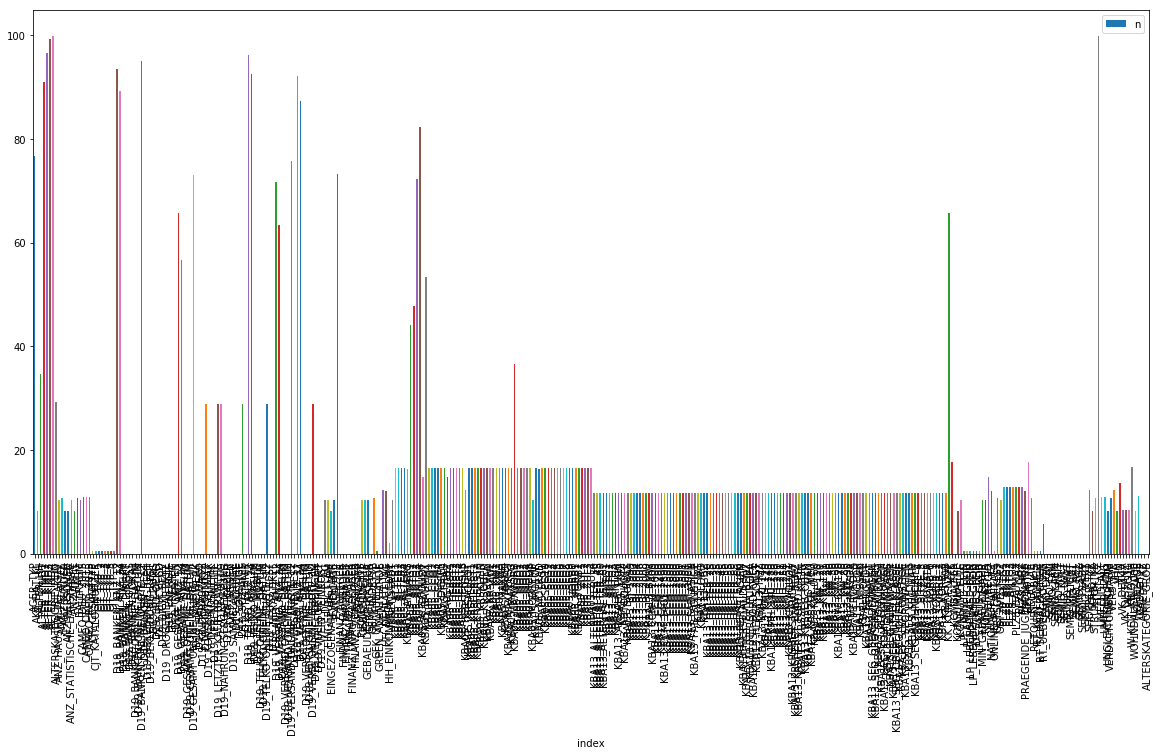

In [20]:
#Visualize the proportion of each column missing values
(azdias_sample_NAN.isna().sum()* 100 / len(azdias_sample_NAN)).reset_index(name="n").plot(kind='bar', x='index', y='n',figsize=(20,10))

In [21]:
#Since many of the columns have missing values above 40%, we will drop these columns
cols_to_drop = azdias_sample_NAN.columns[azdias_sample_NAN.isnull().mean() > .4]
print(cols_to_drop)

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
       'D19_VERSI_ANZ_24', 'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KK_KUNDENTYP',
       'TITEL_KZ'],
      dtype='object')


In [22]:
#Now we will create new dataframe after dropping the previous columns
azdias_sample_filterd = azdias_sample_NAN.loc[:, azdias_sample_NAN.isnull().mean() < .4]

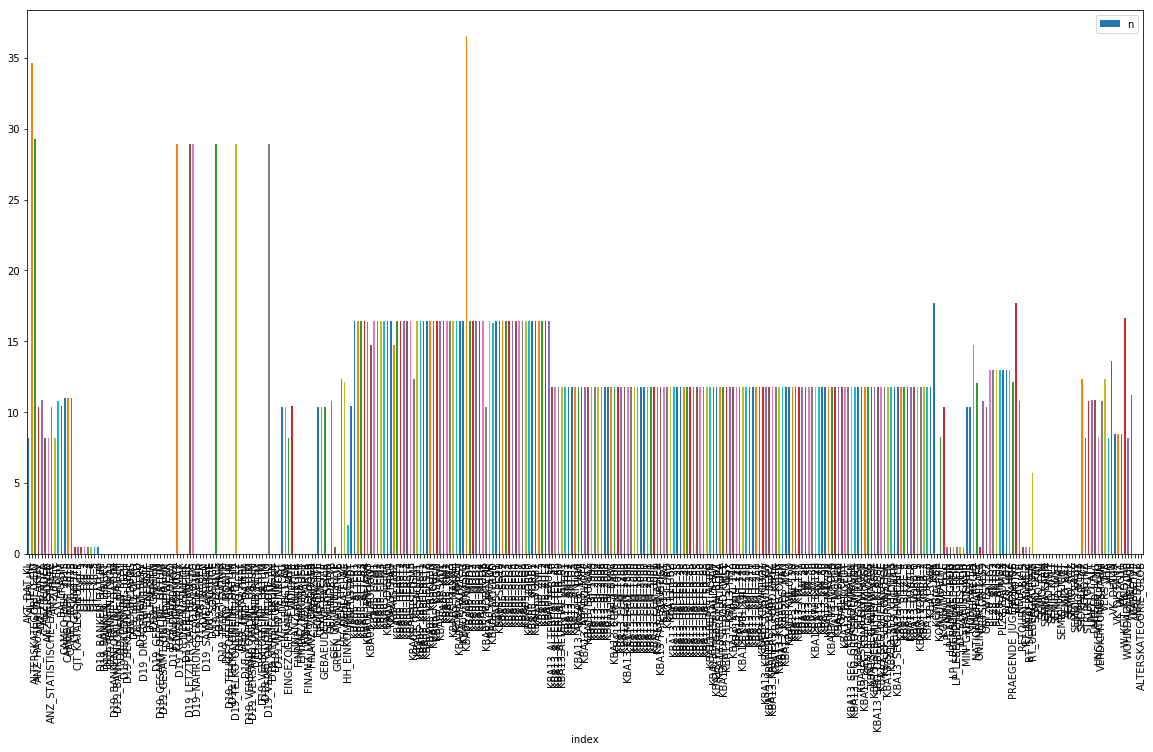

In [23]:
(azdias_sample_filterd.isna().sum()* 100 / len(azdias_sample_filterd)).reset_index(name="n").plot(kind='bar', x='index', y='n',figsize=(20,10))

In [24]:
azdias_sample_filterd.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
387545,8.0,15.0,10.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,3.0,1.0,1.0,1.0,4.0,9.0,2.0,3,1,3
189095,9.0,NaN,NaN,3.0,0.0,0.0,1.0,1.0,0.0,3.0,...,1.0,9.0,10.0,7.0,6.0,9.0,1.0,1,1,4
537650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
1490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,2
656443,1.0,13.0,13.0,14.0,1.0,0.0,1.0,15.0,0.0,1.0,...,2.0,2.0,1.0,1.0,3.0,9.0,7.0,4,2,3


### Step 2.5: Select and Re-Encode Features

Since  unsupervised learning techniques only work on data that is encoded numerically, we need to make a few encoding changes. 

So we will check the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each.

- For binary (two-level) categoricals that take numeric values, we will keep them without change
- For binary variable that takes on non-numeric values we will re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values) we will just drop them from the analysis.

In [25]:
#Filter the categorical/mixed type data columns to explore
azsiad_sample_categ=azdias_sample_filterd.columns[azdias_sample_filterd.dtypes == "object"]
azsiad_sample_categ

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis. we will create two lists, one for binary and one for multi-level

binary=[]
multi_level=[]
for i in azsiad_sample_categ:
    if azdias_sample_filterd[i].nunique() == 2:
        binary.append(i)
    elif azdias_sample_filterd[i].nunique() > 2:
        multi_level.append(i)
multi_level

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM']

In [27]:
#Drop the multi-level categorical columns and create dataframe
azdias_sample_binary=azdias_sample_filterd.drop(multi_level, axis=1)

In [28]:
#Explore the binary categorical column values
for i in binary:
    print(azdias_sample_binary[i].value_counts())

W    63011
O    16871
Name: OST_WEST_KZ, dtype: int64


In [29]:
#Now we will replace "W" value with 1 to have both numerical shape to be able to convert the whole column to numerical
azdias_sample_binary.replace({'OST_WEST_KZ' : { 'W' : 1}}, inplace=True)
for i in binary:
    print(azdias_sample_binary[i].value_counts())

1    63011
O    16871
Name: OST_WEST_KZ, dtype: int64


In [30]:
#Now we will convert the categorical column to numerical to eb able to include in our model
azdias_sample_binary['OST_WEST_KZ'] = pd.to_numeric(azdias_sample_binary['OST_WEST_KZ'], errors='coerce')

In [31]:
azdias_sample_binary.isna().sum()

AKT_DAT_KL                     7313
ALTER_HH                      30851
ALTERSKATEGORIE_FEIN          26095
ANZ_HAUSHALTE_AKTIV            9240
ANZ_HH_TITEL                   9642
ANZ_KINDER                     7313
ANZ_PERSONEN                   7313
ANZ_STATISTISCHE_HAUSHALTE     9240
ANZ_TITEL                      7313
ARBEIT                         9632
BALLRAUM                       9290
CJT_GESAMTTYP                   438
CJT_KATALOGNUTZER               438
CJT_TYP_1                       438
CJT_TYP_2                       438
CJT_TYP_3                       438
CJT_TYP_4                       438
CJT_TYP_5                       438
CJT_TYP_6                       438
D19_BANKEN_DATUM                  0
D19_BANKEN_DIREKT                 0
D19_BANKEN_GROSS                  0
D19_BANKEN_LOKAL                  0
D19_BANKEN_OFFLINE_DATUM          0
D19_BANKEN_ONLINE_DATUM           0
D19_BANKEN_REST                   0
D19_BEKLEIDUNG_GEH                0
D19_BEKLEIDUNG_REST         

In [32]:
# Now we will clean the dataset of all NaN values
#First will create copy of the dataset

azdias_sample_clean=azdias_sample_binary[:]

In [33]:
#We will use imputer function to fillin the NAN values with mean
from sklearn.preprocessing import Imputer

miss_mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

final_azdias = pd.DataFrame(miss_mean_imputer.fit_transform(azdias_sample_clean))
final_clean_azdias=pd.DataFrame(final_azdias)

In [34]:
#To check that no more NAN values
final_clean_azdias.isna().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
304    0
305    0
306    0
307    0
308    0
309    0
310    0
311    0
312    0
313    0
314    0
315    0
316    0
317    0
318    0
319    0
320    0
321    0
322    0
323    0
324    0
325    0
326    0
327    0
328    0
329    0
330    0
331    0
332    0
333    0
Length: 334, dtype: int64

### Step 2.6: Create a Cleaning Function

Now since we've finished cleaning up the general population demographics data, we'll need to perform the same cleaning steps on the customer demographics data.So we will create a cleaning function include all the above steps to apply cleaning in one step

In [35]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ... 
    att_index = features_final.set_index('attribute')
    for item in features_final['attribute']:
        if item in df.columns:
            df[item].replace(att_index.loc[item].loc['missing_or_unknown'],np.NaN,inplace=True)
        else:
            continue

    # select, re-encode, and engineer column values.
    df = df.loc[:, df.isnull().mean() < .4]
    
    categ=df.columns[df.dtypes == "object"]

    binary=[]
    multi_level=[]
    for i in categ:
        if df[i].nunique() == 2:
            binary.append(i)
        elif df[i].nunique() > 2:
            multi_level.append(i)

    df=df.drop(multi_level, axis=1)
    df.replace({'OST_WEST_KZ' : { 'W' : 1}}, inplace=True)
    df['OST_WEST_KZ'] = pd.to_numeric(df['OST_WEST_KZ'], errors='coerce')


    cols = df.columns
    miss_mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    df = miss_mean_imputer.fit_transform(df)
    df=pd.DataFrame(df) 

    # Return the cleaned dataframe.
    return df

## Part 3: Feature Transformation

### Step 3.1: Feature Scaling
Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. We will use StandardScaler to scale each feature to mean 0 and standard deviation 1.

In [36]:
# Apply feature scaling to the general population sample demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standrd_azdians=scaler.fit_transform(final_clean_azdias)
standrd_azdians=pd.DataFrame(standrd_azdians)
standrd_azdians.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,1.027737e+00,-0.100731,-0.868170,-4.107020e-01,-1.301419e-01,-3.195393e-01,2.378354e-01,-4.003526e-01,-0.061835,-1.756516e-01,...,5.351792e-01,-1.833661e+00,-2.105502,-1.867063,-8.890071e-02,0.590767,-1.151314e+00,-0.265683,-1.043188,0.207007
1,1.314419e+00,0.000000,0.000000,-3.453825e-01,-1.301419e-01,-3.195393e-01,-6.545683e-01,-4.717060e-01,-0.061835,-1.756516e-01,...,-1.309509e+00,1.098780e+00,0.794903,0.398732,1.140397e+00,0.590767,-1.701808e+00,-1.739765,-1.043188,1.148757
2,2.546248e-16,0.000000,0.000000,1.160307e-16,2.139943e-17,5.756615e-17,-1.981534e-16,-6.337458e-17,0.000000,-4.690685e-16,...,4.096031e-16,6.511326e-16,0.000000,0.000000,-5.459179e-16,0.000000,4.889371e-16,-0.265683,0.958600,0.207007
3,2.546248e-16,0.000000,0.000000,1.160307e-16,2.139943e-17,5.756615e-17,-1.981534e-16,-6.337458e-17,0.000000,-4.690685e-16,...,4.096031e-16,6.511326e-16,0.000000,0.000000,-5.459179e-16,0.000000,4.889371e-16,-0.265683,0.958600,-0.734743
4,-9.790376e-01,-0.752159,-0.164412,3.731320e-01,2.953841e+00,-3.195393e-01,-6.545683e-01,5.272420e-01,-0.061835,-2.288148e+00,...,-3.871649e-01,-1.467106e+00,-2.105502,-1.867063,-7.035497e-01,0.590767,1.601157e+00,0.471358,0.958600,0.207007


In [37]:
standrd_azdians.shape

(89122, 334)

### Step 3.2:  Dimensionality Reduction

On the scaled data, we will apply dimensionality reduction techniques as follow:

We will Use PCA class to apply principal component analysis on the data to find the vectors of maximal variance in the data. Then we will check the ratio of variance explained by each principal component as well as the cumulative variance explained. 

We will plot the cumulative or sequential values to help in selecting a value for the number of transformed features to retain for the clustering part. With the number of components to keep, we will re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
def do_pca(n_components, data):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

pca,X_pca= do_pca(334, standrd_azdians)

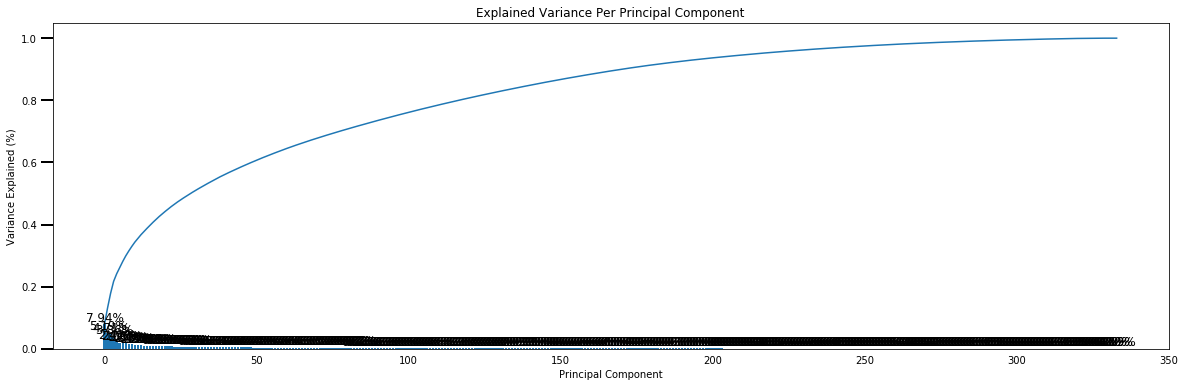

In [41]:
def pca_plot(pca, cumulative=True, figsize=(8,10)):
    '''
    Creates a pca plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    components_numbers = len(pca.explained_variance_ratio_)
    indx = np.arange(components_numbers)
    values = pca.explained_variance_ratio_


    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(values)
    ax.bar(indx, values)
    ax.plot(indx, cumvals)
    for i in range(components_numbers):
        ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), (indx[i]+0.2, values[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

pca_plot(pca)

In [42]:
'''Re-apply PCA to the data while selecting for number of components to retain. 
We will select 150 components as represent almost 90% of the variance in the dataset
'''
pca,X_pca= do_pca(150, standrd_azdians)

In [43]:
X_pca.shape

(89122, 150)

## Part 4: Clustering

### Step 4.1: Apply Clustering to General Population Sample

Now we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.
- Compute the average difference from each point to its assigned cluster's center.
- We will perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. 
- Once we select a final number of clusters to use, we will re-fit KMeans to perform the clustering operation.

In [44]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(5,30,5))

for center in centers:
    scores.append(get_kmeans_score(X_pca, center))

In [45]:
scores

[22185796.574982058,
 20975092.773961518,
 20323066.136784848,
 19893274.405469157,
 19543713.919980492]

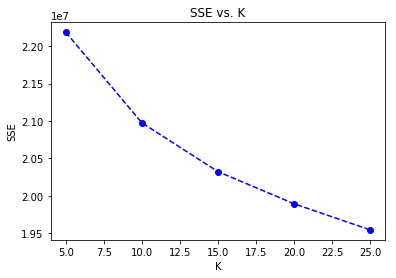

In [46]:
# We will visualize the change in within-cluster distance across number of clusters.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data sample and we will use 15 clusters.
kmeans_mod = KMeans(n_clusters=15)

model_pop = kmeans_mod.fit(X_pca)

pred_pop = model_pop.predict(X_pca)
pred_pop

array([ 7,  0,  1, ...,  2, 12,  7], dtype=int32)

## Part 5: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Step 5.1: Apply All Steps to the Customer Data

Now we have clusters and cluster centers for the general population, we will work on check how the customer data maps on to those clusters.

- We will when load the customers data.
- We will take 10% sampling ratio as we did with the genral population data.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the clean function created earlier.

In [48]:
#Load Customers data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [50]:
#Drop the "LNR" column as it represent the user id and not needed now
customers = customers.drop("LNR", axis=1)

In [51]:
#Check the data shape
customers.shape

(191652, 368)

In [52]:
#Check the data types counts
customers.dtypes.value_counts()

float64    267
int64       93
object       8
dtype: int64

In [53]:
# Take sample from the customers dataset to be same proportion with the general population data.
customers_sample = customers.sample(frac=0.1)

In [54]:
#Check the extra columns compared to the general popoulation data
customers_sample.select_dtypes(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
19432,2A,2,12,D19_SONSTIGE,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
23917,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W,FOOD,MULTI_BUYER
6986,9D,9,51,D19_BUCH_CD,1992-02-10 00:00:00,W,COSMETIC,SINGLE_BUYER
127480,4C,4,24,D19_ENERGIE,1995-08-15 00:00:00,W,COSMETIC,MULTI_BUYER
73868,4A,4,22,D19_BEKLEIDUNG_REST,1992-02-10 00:00:00,W,FOOD,MULTI_BUYER
83507,2A,2,12,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
91359,8B,8,41,D19_VOLLSORTIMENT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
128331,6C,6,44,D19_GARTEN,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
186265,9D,9,51,D19_BUCH_CD,2011-11-24 00:00:00,W,COSMETIC,SINGLE_BUYER
102085,5C,5,33,NaN,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER


In [55]:
#We will drop the extra columns to match the general population shape
customers_sample.drop(['PRODUCT_GROUP','CUSTOMER_GROUP'], axis=1, inplace=True)

In [56]:
customers_sample.select_dtypes(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
19432,2A,2,12,D19_SONSTIGE,1992-02-10 00:00:00,W
23917,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
6986,9D,9,51,D19_BUCH_CD,1992-02-10 00:00:00,W
127480,4C,4,24,D19_ENERGIE,1995-08-15 00:00:00,W
73868,4A,4,22,D19_BEKLEIDUNG_REST,1992-02-10 00:00:00,W
83507,2A,2,12,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
91359,8B,8,41,D19_VOLLSORTIMENT,1992-02-10 00:00:00,W
128331,6C,6,44,D19_GARTEN,1992-02-12 00:00:00,W
186265,9D,9,51,D19_BUCH_CD,2011-11-24 00:00:00,W
102085,5C,5,33,NaN,1992-02-12 00:00:00,W


In [57]:
#Now we will apply the clean function on the customers data
cleaned_customers=clean_data(customers_sample)

In [58]:
#Recheck the clean data shape to ensure its matching with the general population shape
cleaned_customers.shape

(19165, 334)

In [59]:
#Ensure no missing values in customers data
cleaned_customers.isna().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
304    0
305    0
306    0
307    0
308    0
309    0
310    0
311    0
312    0
313    0
314    0
315    0
316    0
317    0
318    0
319    0
320    0
321    0
322    0
323    0
324    0
325    0
326    0
327    0
328    0
329    0
330    0
331    0
332    0
333    0
Length: 334, dtype: int64

### Step 5.2: Compare Customer Data to Demographics Data

Here, we will compare the two cluster distributions for the data demographics of the general population and the customer data for a mail-order sales company to see where the strongest customer base for the company is.

We will check the proportion of persons in each cluster for the general population, and the proportions for the customers. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population then that suggests the people in that cluster to be a target audience for the company. 

On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data suggests that group of persons to be outside of the target demographics.

What we will do is to compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. 

In [60]:
#Apply standard scaler to the customer sample data
customers_stand=scaler.fit_transform(cleaned_customers)
cust_pca=pca.fit_transform(customers_stand)
pred_cust=model_pop.predict(cust_pca)
pred_cust

array([14,  1,  9, ..., 13, 13, 13], dtype=int32)

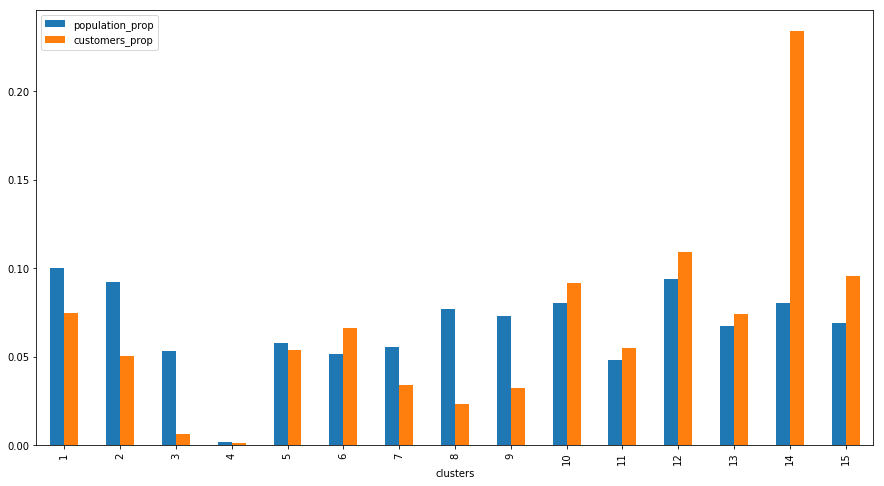

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

pop_prop = []
cust_prop = []
x = [i+1 for i in range(15)]
for i in range(15):
    pop_prop.append((pred_pop == i).sum()/len(pred_pop))
    cust_prop.append((pred_cust == i).sum()/len(pred_cust))
    
prop_data = pd.DataFrame({'clusters' : x, 'population_prop' : pop_prop, 'customers_prop':cust_prop})

prop_data.plot(x='clusters', y = ['population_prop', 'customers_prop'], kind='bar', figsize=(15,8))
plt.show()

### Observation
From the above distirbutions its clear that the company's customer base is not universal as the cluster assignment proportions not similar between the two. Its clear that company should target clusters like 14,12 and 15 where customers resides the most and neglect clusters like 3,4,and 8 where customers are least representative

## Part 6: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Step 6.1: Apply All Steps to the Mailout Train Data

- We will when load the Mailout Train data.
- We will take 10% sampling ratio as we did earlier for sake of proportional comparison
- Apply the same feature wrangling, selection, and engineering steps to the Mailout data using the clean function created earlier.

In [64]:
Mailout_data_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
Mailout_data_train.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [65]:
Mailout_data_train.shape

(42962, 367)

In [66]:
Mailout_data_train = Mailout_data_train.drop("LNR", axis=1)

In [67]:
Mailout_data_sample=Mailout_data_train.sample(frac=0.1)

In [68]:
Mailout_data_sample['RESPONSE'].value_counts()

0    4249
1      47
Name: RESPONSE, dtype: int64

In [69]:
mailout_label_train = Mailout_data_sample["RESPONSE"]

In [70]:
mailout_data_train = Mailout_data_sample.drop("RESPONSE", axis=1)

In [71]:
mailout_data_train.shape

(4296, 365)

In [72]:
mailout_data_train.select_dtypes(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
15054,5B,5,32,D19_VERSICHERUNGEN,1997-07-30 00:00:00,O
12950,6B,6,43,D19_UNBEKANNT,1992-02-12 00:00:00,W
10947,6B,6,43,D19_VERSAND_REST,1992-02-10 00:00:00,O
6699,5D,5,34,D19_RATGEBER,1992-02-10 00:00:00,W
36895,6E,6,45,D19_TELKO_MOBILE,1992-02-10 00:00:00,O
30567,9E,9,55,D19_UNBEKANNT,1992-02-10 00:00:00,W
1226,2C,2,14,D19_SAMMELARTIKEL,1996-01-26 00:00:00,W
27425,NaN,NaN,NaN,D19_TELKO_MOBILE,NaN,NaN
14573,6B,6,43,D19_VOLLSORTIMENT,1992-02-12 00:00:00,W
16253,5C,5,33,D19_UNBEKANNT,1992-02-10 00:00:00,W


In [73]:
#Apply the clean function
clean_mailout_train=clean_data(mailout_data_train)

In [74]:
clean_mailout_train.shape

(4296, 334)

In [75]:
#We will test and split our data to prepare the model
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(clean_mailout_train, mailout_label_train, test_size=0.2, random_state=1)

In [76]:
#We will apply Supervised logistic regression model
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
#kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
lr = LogisticRegression(random_state=1)

In [77]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
predictions = lr.predict(X_val)

In [79]:
#Calculate the model prediction accuracy on the train data
score =lr.score(X_val, y_val)
print(score)

0.974418604651


### Step 6.2: Apply All Steps & Model chosen to the Mailout Test Data

In [125]:
Mailout_data_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
Mailout_data_test.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42833, 366)

In [126]:
Mailout_data_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [127]:
Mailout_data_test_sample=Mailout_data_test.sample(frac=0.1)

In [128]:
LNR = Mailout_data_test_sample['LNR'].tolist()

In [129]:
Mailout_data_test_sample= Mailout_data_test_sample.drop("LNR", axis=1)

In [130]:
clean_mailout_test=clean_data(Mailout_data_test_sample)

In [131]:
clean_mailout_test.shape

(4283, 334)

In [132]:
model = LogisticRegression(random_state=1)
model.fit(X_val, y_val)
results = model.predict(clean_mailout_test)

In [133]:
results.shape

(4283,)

In [134]:
results = pd.DataFrame({'RESPONSE':results})
results['LNR'] = LNR
result = results[['LNR', 'RESPONSE']]
result.head()

,LNR,RESPONSE
0,18677,0
1,13549,0
2,37994,0
3,48823,0
4,23472,0


In [135]:
result['RESPONSE'].value_counts()

0    4267
1      16
Name: RESPONSE, dtype: int64